In [2]:
stopwords = [
    "a",
    "about",
    "above",
    "after",
    "again",
    "against",
    "all",
    "am",
    "an",
    "and",
    "any",
    "are",
    "as",
    "at",
    "be",
    "because",
    "been",
    "before",
    "being",
    "below",
    "between",
    "both",
    "but",
    "by",
    "could",
    "did",
    "do",
    "does",
    "doing",
    "down",
    "during",
    "each",
    "few",
    "for",
    "from",
    "further",
    "had",
    "has",
    "have",
    "having",
    "he",
    "hed",
    "hes",
    "her",
    "here",
    "heres",
    "hers",
    "herself",
    "him",
    "himself",
    "his",
    "how",
    "hows",
    "i",
    "id",
    "ill",
    "im",
    "ive",
    "if",
    "in",
    "into",
    "is",
    "it",
    "its",
    "itself",
    "lets",
    "me",
    "more",
    "most",
    "my",
    "myself",
    "nor",
    "of",
    "on",
    "once",
    "only",
    "or",
    "other",
    "ought",
    "our",
    "ours",
    "ourselves",
    "out",
    "over",
    "own",
    "same",
    "she",
    "shed",
    "shell",
    "shes",
    "should",
    "so",
    "some",
    "such",
    "than",
    "that",
    "thats",
    "the",
    "their",
    "theirs",
    "them",
    "themselves",
    "then",
    "there",
    "theres",
    "these",
    "they",
    "theyd",
    "theyll",
    "theyre",
    "theyve",
    "this",
    "those",
    "through",
    "to",
    "too",
    "under",
    "until",
    "up",
    "very",
    "was",
    "we",
    "wed",
    "well",
    "were",
    "weve",
    "were",
    "what",
    "whats",
    "when",
    "whens",
    "where",
    "wheres",
    "which",
    "while",
    "who",
    "whos",
    "whom",
    "why",
    "whys",
    "with",
    "would",
    "you",
    "youd",
    "youll",
    "youre",
    "youve",
    "your",
    "yours",
    "yourself",
    "yourselves",
]

In [3]:
# Load data from JSON file

import json
from bs4 import BeautifulSoup
import string

sentences = []
labels = []

with open("./sarcasm.json", "r") as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []

table = str.maketrans("", "", string.punctuation)

for item in datastore:
    sentence = item["headline"].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")

    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()

    words = sentence.split()

    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "

    sentences.append(filtered_sentence)
    labels.append(item["is_sarcastic"])
    urls.append(item["article_link"])

/var/folders/yq/6hjjmqgj63s0mxztlhxls6r80000gn/T/ipykernel_19278/1492615037.py:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

training_size = 23000

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

vocab_size = 2000
max_length = 85
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(
    training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(
    testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

In [5]:
import numpy as np
import keras

In [6]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [7]:
model = keras.Sequential(
    [
        # Original 16-dimmensional Embedding
        # keras.layers.Embedding(20000, 16),
        # Fine-tuned 16-dimmensional Embedding
        keras.layers.Embedding(vocab_size, 7),
        keras.layers.GlobalAveragePooling1D(),
        # Layer without regularization
        # keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(
            8, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)
        ),
        # Inefficient Dropout due to small dense layer
        # keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Default Optimizer before fine-tuning Adam
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fine-tuned Adam Optimizer
# adam = keras.optimizers.Adam(
#     learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False
# )
# model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])

history = model.fit(
    training_padded,
    training_labels,
    epochs=100,
    validation_data=(testing_padded, testing_labels),
    verbose=1,
)

2024-08-26 20:26:36.331937: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-26 20:26:36.332048: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-26 20:26:36.332056: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-26 20:26:36.333276: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-26 20:26:36.333837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-08-26 20:26:37.526930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


719/719 [==============================] - 19s 19ms/step - loss: 0.7140 - accuracy: 0.5242 - val_loss: 0.6925 - val_accuracy: 0.5273
Epoch 2/100
719/719 [==============================] - 13s 18ms/step - loss: 0.6910 - accuracy: 0.5231 - val_loss: 0.6883 - val_accuracy: 0.5277
Epoch 3/100
719/719 [==============================] - 14s 20ms/step - loss: 0.6812 - accuracy: 0.5973 - val_loss: 0.6663 - val_accuracy: 0.6711
Epoch 4/100
719/719 [==============================] - 15s 20ms/step - loss: 0.6492 - accuracy: 0.6867 - val_loss: 0.6294 - val_accuracy: 0.7033
Epoch 5/100
719/719 [==============================] - 13s 19ms/step - loss: 0.6132 - accuracy: 0.7199 - val_loss: 0.5998 - val_accuracy: 0.7231
Epoch 6/100
719/719 [==============================] - 15s 20ms/step - loss: 0.5838 - accuracy: 0.7421 - val_loss: 0.5771 - val_accuracy: 0.7412
Epoch 7/100
719/719 [==============================] - 12s 17ms/step - loss: 0.5595 - accuracy: 0.7589 - val_loss: 0.5604 - val_accuracy: 0.75

KeyboardInterrupt: 

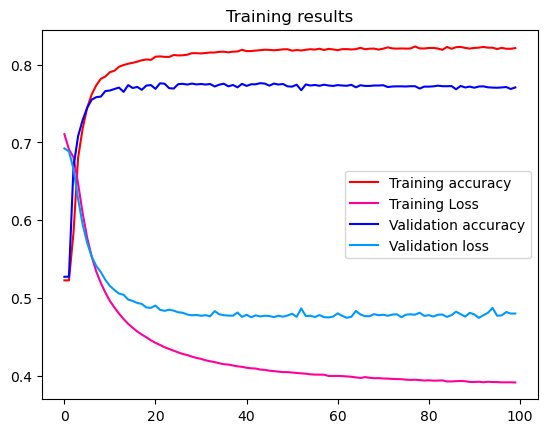

In [81]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.title("Training results")

plt.plot(epochs, acc, "#ff0000", label="Training accuracy")
plt.plot(epochs, loss, "#ff0099", label="Training Loss")
plt.plot(epochs, val_acc, "#0000ff", label="Validation accuracy")
plt.plot(epochs, val_loss, "#0099ff", label="Validation loss")

plt.legend()

plt.show()

In [83]:
sentences = [
    "granny starting to fear spiders in the garden might be real",
    "game of thrones season finale showing this sunday night",
    "TensorFlow book will be a best seller",
]

sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type)

print(model.predict(padded))

1/1 [==============================] - 0s 18ms/step
[[0.67906004]
 [0.14853866]
 [0.09606411]]


In [84]:
import io

# Get reverse mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Get weights from embedding layer
e = model.layers[0]
weights = e.get_weights()[0]

# Write weights to file
out_v = io.open("vecs.tsv", "w", encoding="utf-8")
out_m = io.open("meta.tsv", "w", encoding="utf-8")

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write("\t".join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

# Reducing Overfitting

# 1. Fine-tune the learning rate

A high learing rate can cause the model to overfit. The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. A high learning rate can cause the model to converge too quickly to a suboptimal solution.

Can be done by fine-tuning the optimizer's learning rate:

```python
adam = keras.optimizers.Adam(
    learning_rate=0.0001, # reduced from 0.001
    beta_1=0.9,
    beta_2=0.999,
    amsgrad=False
)

model.compile(
  optimizer=adam,
  # ...
)
```

# 2. Remove irrelevant examples from the dataset

In our sarcasm database, there are a few words that make up a large portion of the dataset. Removing some of these words can help reduce overfitting.

To get the most common words in the dataset in descending order:

```python
# Get the word frequency
from collections import OrederedDict

word_counts = tokenizer.word_counts
ordered_list = (OrderedDict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True)))

print(ordered_list)

```

# 3. Fine-tuning the embedding size

The embedding size should be the 4-th root of the number of unique words in the dataset. This is a rule of thumb that can be used to fine-tune the embedding dimension.

For this example, it means reducing the Embedding size to 7.

# 4. Changing the model architecture

In this example, after reducing the embedding size, we can also reduce the number of inputs in the dense layer to 8. (embedding size + 1)

# 5. Using dropouts

To introduce some randomness in the model, we can use dropouts. This can help reduce overfitting.

In this example, having a Dropout layer in such a small model (only 8 neurons in the dense layer) will not be very effective.

# 6. Regularization

Regularization is a technique used to punish neurons that are too active. This can help reduce overfitting.

There are two types of regularization: L1 and L2

- L1 - lasso regularization (least absolute shrinkage and selection operator) - helps ignore almost-zero weights
- L2 - ridge regularization (Tikhonov regularization) - helps reduce the weights of large values

The two can be combined to form the L1L2 (elastic) regularization.
